In [15]:
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. Carregando dados do CEPEA
# ---------------------------------------------------------
caminho_arquivo = '../data/raw/cepea_etanol_limpo.xlsx'

try:
    df_etanol = pd.read_excel(caminho_arquivo, header=3, engine='openpyxl')
    df_etanol = df_etanol.iloc[:, 0:2] 
    df_etanol.columns = ['Data', 'Preco_Etanol']
    
    # Tratamento de erro de conversão (BR vs US)
    df_etanol['Preco_Etanol'] = df_etanol['Preco_Etanol'].astype(str)
    df_etanol['Preco_Etanol'] = df_etanol['Preco_Etanol'].str.replace('.', '', regex=False)
    df_etanol['Preco_Etanol'] = df_etanol['Preco_Etanol'].str.replace(',', '.', regex=False)
    df_etanol['Preco_Etanol'] = pd.to_numeric(df_etanol['Preco_Etanol'])
    
    df_etanol['Data'] = pd.to_datetime(df_etanol['Data'], dayfirst=True)
    df_etanol.set_index('Data', inplace=True)
    
    print("✅ Dados do Etanol carregados!")
    print(df_etanol.head())

except Exception as e:
    print(f"❌ Erro: {e}")

✅ Dados do Etanol carregados!
            Preco_Etanol
Data                    
2015-01-02        1209.5
2015-01-05        1205.0
2015-01-06        1222.5
2015-01-07        1216.0
2015-01-08        1214.0


⏳ Baixando dados do mercado (Modo Compatibilidade)...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

✅ Mercado baixado e corrigido:
            Petroleo_Brent   Dolar  Acucar
Date                                      
2025-11-21       62.560001  5.3323   14.78
2025-11-24       63.369999  5.4021   14.82
2025-11-25             NaN  5.3868     NaN
2025-11-26             NaN  5.3794   15.12
2025-11-27       62.840000  5.3475     NaN

💾 Arquivo salvo: dataset_consolidado.csv


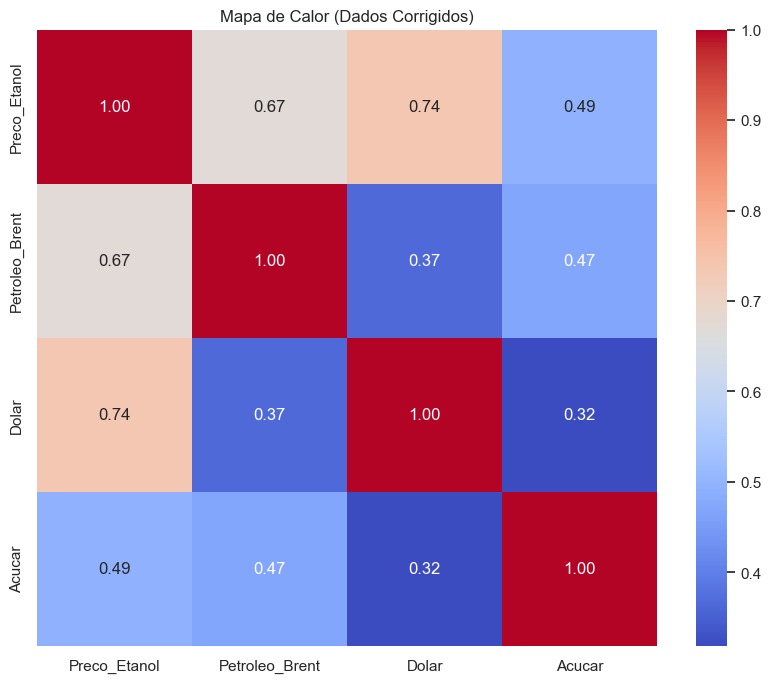

In [17]:
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 2. Carregando Mercados (MÉTODO BLINDADO - SEM RENAME)
# ---------------------------------------------------------
print("⏳ Baixando dados do mercado (Modo Compatibilidade)...")

# 1. Baixamos os dados brutos
# O parametro auto_adjust=True ajuda a pegar o preço real de fechamento
raw_petroleo = yf.download('BZ=F', period="10y", auto_adjust=True)
raw_dolar = yf.download('BRL=X', period="10y", auto_adjust=True)
raw_acucar = yf.download('SB=F', period="10y", auto_adjust=True)

# 2. Extraímos apenas a coluna de fechamento (Close)
# Se o yfinance devolver muitas colunas, pegamos a 'Close' especificamente
# O comando squeeze() transforma Tabela em Lista (Series), que é mais fácil de mexer
petroleo_series = raw_petroleo['Close'].squeeze()
dolar_series = raw_dolar['Close'].squeeze()
acucar_series = raw_acucar['Close'].squeeze()

# 3. Juntamos tudo
df_mercado = pd.concat([petroleo_series, dolar_series, acucar_series], axis=1)

# 4. FORÇAMOS OS NOMES (Aqui não tem como dar erro de 'callable')
# Definimos explicitamente quem é quem na ordem que colocamos no concat
df_mercado.columns = ['Petroleo_Brent', 'Dolar', 'Acucar']

# Garantindo data
df_mercado.index = pd.to_datetime(df_mercado.index)

print("✅ Mercado baixado e corrigido:")
print(df_mercado.tail()) 

# ---------------------------------------------------------
# 3. Unificando e Salvando
# ---------------------------------------------------------
# Se der erro dizendo que 'df_etanol' não existe, rode a primeira célula do notebook de novo
try:
    df_final = df_etanol.join(df_mercado, how='inner')
    df_final.dropna(inplace=True)

    df_final.to_csv('../data/processed/dataset_consolidado.csv')
    print("\n💾 Arquivo salvo: dataset_consolidado.csv")

    # Validação Visual
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_final.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Mapa de Calor (Dados Corrigidos)")
    plt.show()

except NameError:
    print("❌ ERRO: A variável 'df_etanol' sumiu da memória.")
    print("👉 SOLUÇÃO: Rode a Célula 1 (aquela que lê o Excel do CEPEA) novamente antes de rodar esta.")